# Demo of PyMC models

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pathlib

In [2]:
# %config InlineBackend.figure_format = 'svg'
az.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
export_images = True

## Synthetic Control

In [5]:
sc_data_path = (
    pathlib.Path.cwd().parents[0] / "causalpy" / "data" / "synthetic_control.csv"
)
df = pd.read_csv(sc_data_path)
treatment_time = 70

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


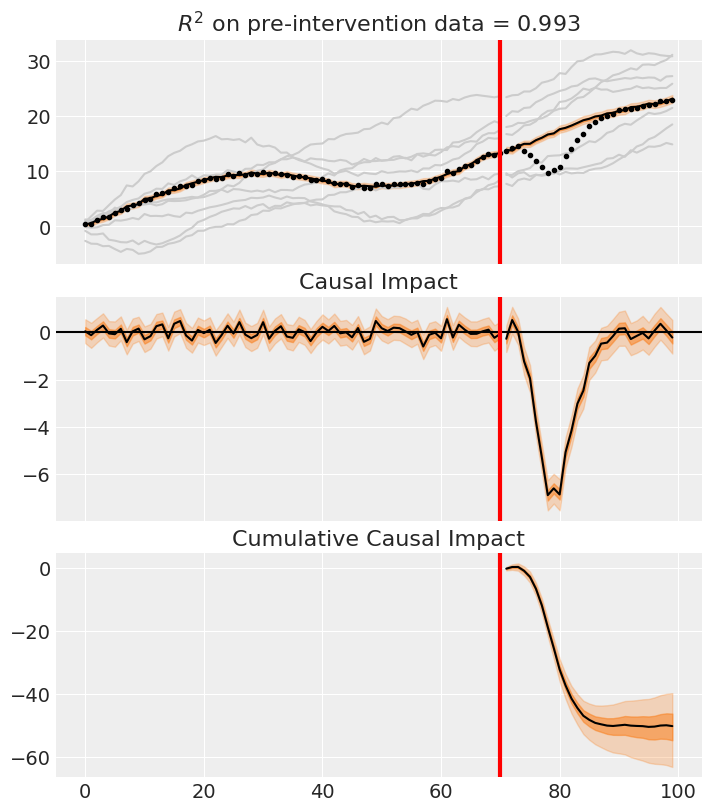

In [6]:
from causalpy.pymc_experiments import SyntheticControl
from causalpy.pymc_models import WeightedSumFitter

# Note, we do not want an intercept in this model
result = SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    prediction_model=WeightedSumFitter(),
)

result.plot()

if export_images:
    plt.savefig(
        pathlib.Path.cwd().parents[0] / "img" / "synthetic_control_pymc.svg",
        bbox_inches="tight",
        format="svg",
    )

## Interrupted time series

In [7]:
its_data_path = pathlib.Path.cwd().parents[0] / "causalpy" / "data" / "its.csv"
df = pd.read_csv(its_data_path, parse_dates=["date"])
df.set_index("date", inplace=True)
treatment_time = pd.to_datetime("2017-01-01")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


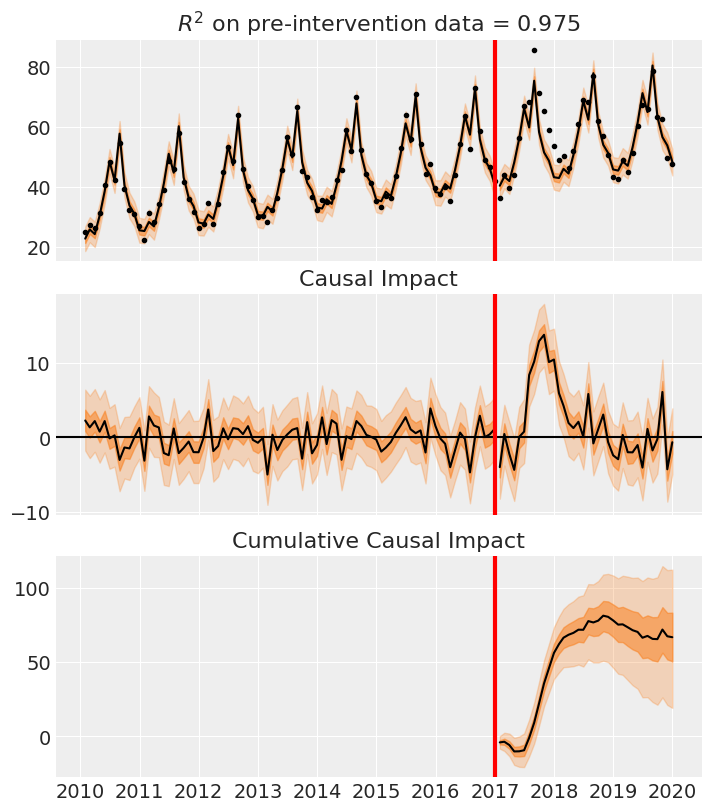

In [8]:
from causalpy.pymc_experiments import InterruptedTimeSeries
from causalpy.pymc_models import LinearRegression

result = InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    prediction_model=LinearRegression(),
)

fig, ax = result.plot()

if export_images:
    plt.savefig(
        pathlib.Path.cwd().parents[0] / "img" / "interrupted_time_series_pymc.svg",
        bbox_inches="tight",
        format="svg",
    )

## Difference in differences

In [9]:
did_data_path = pathlib.Path.cwd().parents[0] / "causalpy" / "data" / "did.csv"

df = pd.read_csv(did_data_path)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


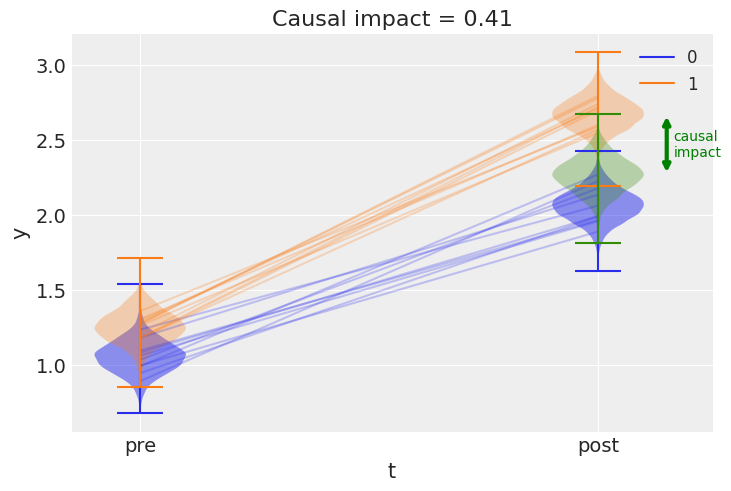

In [10]:
from causalpy.pymc_experiments import DifferenceInDifferences
from causalpy.pymc_models import LinearRegression

# NOTE: `treated` is a deterministic function of `t` and `group`. So add this function into the formula.

result = DifferenceInDifferences(
    df, formula="y ~ 1 + group + t + treated:group", prediction_model=LinearRegression()
)
fig, ax = result.plot()

if export_images:
    plt.savefig(
        pathlib.Path.cwd().parents[0] / "img" / "difference_in_differences_pymc.svg",
        bbox_inches="tight",
        format="svg",
    )

## Regression discontinuity

In [11]:
rd_data_path = (
    pathlib.Path.cwd().parents[0] / "causalpy" / "data" / "regression_discontinuity.csv"
)
df = pd.read_csv(rd_data_path)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


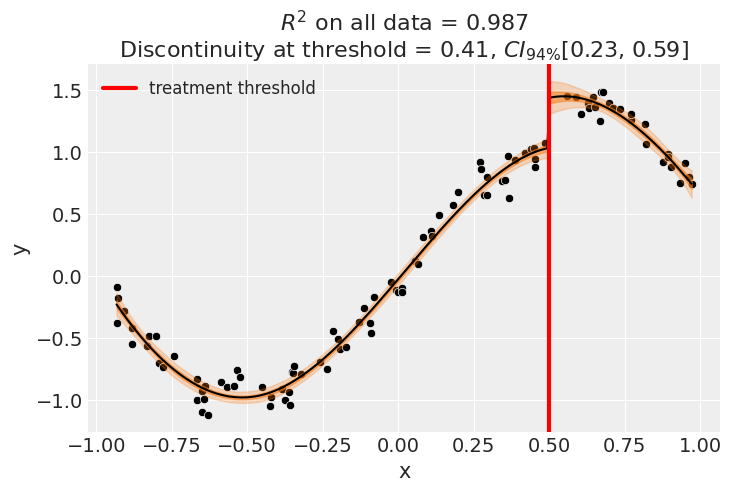

In [12]:
from causalpy.pymc_experiments import RegressionDiscontinuity
from causalpy.pymc_models import LinearRegression

result = RegressionDiscontinuity(
    df,
    formula="y ~ 1 + bs(x, df=6) + treated",
    prediction_model=LinearRegression(),
    treatment_threshold=0.5,
)
result.plot()

if export_images:
    plt.savefig(
        pathlib.Path.cwd().parents[0] / "img" / "regression_discontinuity_pymc.svg",
        bbox_inches="tight",
        format="svg",
    )

Run the 'drinking example' from the RDD chapter of [Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/16-Regression-Discontinuity-Design.html).

In [13]:
rd_data_path = pathlib.Path.cwd().parents[0] / "causalpy" / "data" / "drinking.csv"
df = (
    pd.read_csv(rd_data_path)[["agecell", "all", "mva", "suicide"]]
    .rename(columns={"agecell": "age"})
    .assign(treated=lambda df_: df_.age > 21)
    .dropna(axis=0)
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


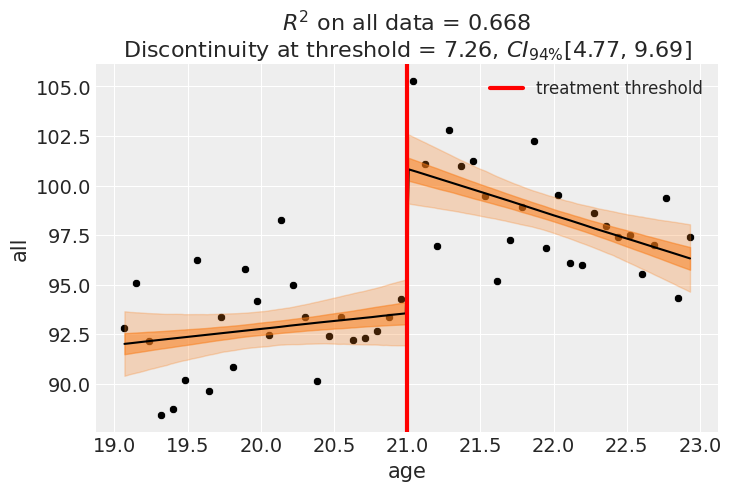

In [14]:
from causalpy.pymc_experiments import RegressionDiscontinuity
from causalpy.pymc_models import LinearRegression

result = RegressionDiscontinuity(
    df,
    formula="all ~ 1 + age + treated + age:treated",
    running_variable_name="age",
    outcome_variable_name="all",
    prediction_model=LinearRegression(),
    treatment_threshold=21,
)
result.plot();

In [15]:
result.summary()

Difference in Differences experiment
Formula: all ~ 1 + age + treated + age:treated
Running variable: age
Threshold on running variable: 21

Results:
Discontinuity at threshold = 7.26
Model coefficients:
	Intercept		76.56, 94% HDI [48.44, 104.04]
	treated[T.True]		73.25, 94% HDI [34.61, 113.30]
	age		0.81, 94% HDI [-0.56, 2.22]
	age:treated[T.True]		-3.14, 94% HDI [-5.01, -1.30]
	sigma		2.23, 94% HDI [1.86, 2.67]


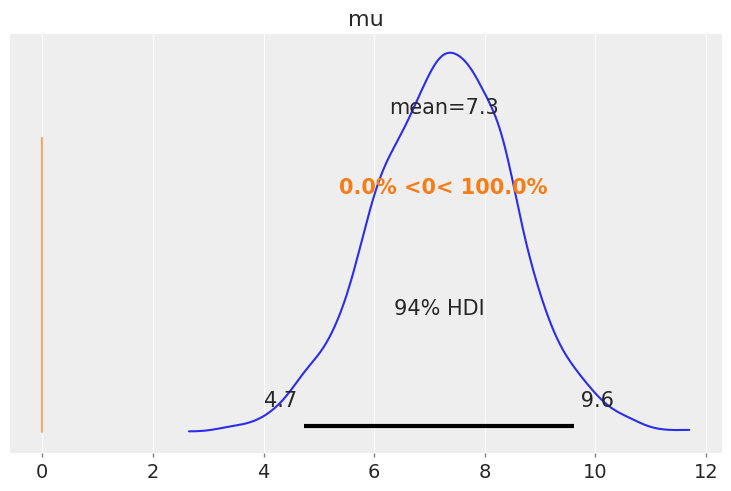

In [16]:
# plot the posterior over the discontinuity at threshold
az.plot_posterior(result.discontinuity_at_threshold, ref_val=0);